In [13]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings

warnings.filterwarnings("ignore")

In [14]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    rows.extend(row_data)  # Extend to add multiple rows

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(train_stats_file, cfg_data)
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            variables[key.strip()] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    # Assuming the checkpoint contains 'training_stats' and 'validation_stats'
    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])

    # Process each stats type and return combined results
    return process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [15]:
df = process_experiment(
    r"D:\Work\repos\RL\minatar_work\experiments\training\training_without_redo\results\2023Nov27-105347_configs"
)
df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_frames_min', 'episode_frames_max',
       'episode_frames_mean', 'episode_frames_median', 'episode_frames_std',
       'episode_losses_min', 'episode_losses_max', 'episode_losses_mean',
       'episode_losses_median', 'episode_losses_std', 'episode_max_qs_min',
       'episode_max_qs_max', 'episode_max_qs_mean', 'episode_max_qs_median',
       'episode_max_qs_std', 'policy_trained_times', 'target_trained_times',
       'epoch_time', 'estimator.args_.lin_hidden_out_size',
       'estimator.args_.conv_hidden_out_size', 'environment'],
      dtype='object')

In [16]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,...,episode_max_qs_max,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,estimator.args_.lin_hidden_out_size,estimator.args_.conv_hidden_out_size,environment
0,training,200000,0.0,8.0,1.058889,1.0,1.254211,6,92,17.068533,...,33.416019,-13.878698,-7.854648,24.623339,48749.0,48.0,0 days 00:06:31.126365,64,16,breakout
1,training,400000,0.0,12.0,3.944071,4.0,2.002037,6,138,48.005761,...,21.624430,-29.435783,-21.234791,29.898210,50000.0,48.0,0 days 00:07:23.198718,64,16,breakout
2,training,600000,0.0,26.0,6.106990,6.0,3.017891,6,238,71.324536,...,20.273935,-38.151639,-38.831211,24.685367,50000.0,52.0,0 days 00:07:32.437508,64,16,breakout
3,training,800000,0.0,28.0,7.397009,7.0,4.622787,6,384,85.452137,...,0.869885,-37.503186,-35.189066,19.533498,50000.0,48.0,0 days 00:07:23.511358,64,16,breakout
4,training,1000000,0.0,27.0,7.808597,7.0,3.811749,6,316,90.485068,...,-6.602756,-39.813848,-34.054815,20.505020,50000.0,52.0,0 days 00:07:29.420437,64,16,breakout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,validation,3200000,0.0,177.0,38.464286,29.0,30.333836,6,7902,1127.178571,...,24.375334,5.101309,5.232816,2.979750,NaN,NaN,0 days 00:00:50.230347,128,32,breakout
236,validation,3400000,1.0,145.0,48.184211,50.0,34.759213,16,23956,3737.736842,...,15.558659,7.426354,7.266645,2.612604,NaN,NaN,0 days 00:00:53.099309,128,32,breakout
237,validation,3600000,0.0,144.0,27.391304,27.0,17.850805,6,25996,1613.717391,...,20.697996,8.335195,8.511435,2.890036,NaN,NaN,0 days 00:00:56.491039,128,32,breakout
238,validation,3800000,1.0,178.0,55.097222,51.5,39.936811,16,17192,1774.388889,...,18.445431,7.910634,8.138067,3.195716,NaN,NaN,0 days 00:00:47.809437,128,32,breakout


In [17]:
df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_frames_min', 'episode_frames_max',
       'episode_frames_mean', 'episode_frames_median', 'episode_frames_std',
       'episode_losses_min', 'episode_losses_max', 'episode_losses_mean',
       'episode_losses_median', 'episode_losses_std', 'episode_max_qs_min',
       'episode_max_qs_max', 'episode_max_qs_mean', 'episode_max_qs_median',
       'episode_max_qs_std', 'policy_trained_times', 'target_trained_times',
       'epoch_time', 'estimator.args_.lin_hidden_out_size',
       'estimator.args_.conv_hidden_out_size', 'environment'],
      dtype='object')

In [20]:
df["model"] = df["estimator.args_.conv_hidden_out_size"] + "_" + df["estimator.args_.lin_hidden_out_size"]

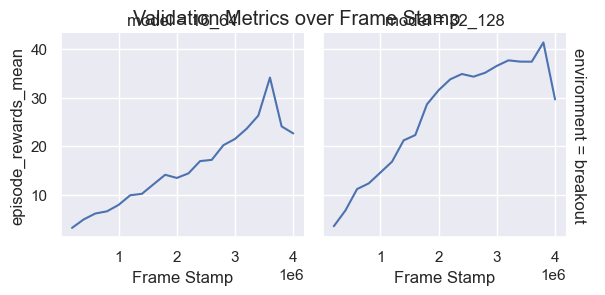

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Assuming 'df' is your DataFrame
# Filter for rows where epoch_type is 'validation'
validation_df = df[df['epoch_type'] == 'validation']

# Define your selected_metric and selected_var
selected_metric = 'episode_rewards_mean'  
selected_var = 'model'  

# Create the FacetGrid
g = sns.FacetGrid(validation_df, row='environment', col=selected_var, margin_titles=True, height=3)
g.map(sns.lineplot, 'frame_stamp', selected_metric, ci=None)

# Optional: Adjust the plot's aesthetics
g.set_axis_labels('Frame Stamp', selected_metric)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Validation Metrics over Frame Stamp')

# Show the plot
plt.show()

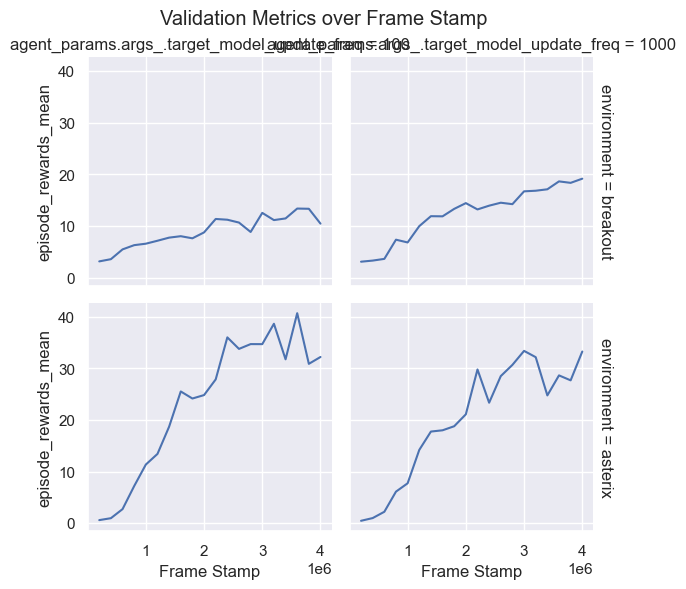

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Assuming 'df' is your DataFrame
# Filter for rows where epoch_type is 'validation'
validation_df = df[df['epoch_type'] == 'validation']

# Define your selected_metric and selected_var
selected_metric = 'episode_rewards_mean'  
selected_var = 'agent_params.args_.target_model_update_freq'  

# Create the FacetGrid
g = sns.FacetGrid(validation_df, row='environment', col=selected_var, margin_titles=True, height=3)
g.map(sns.lineplot, 'frame_stamp', selected_metric, ci=None)

# Optional: Adjust the plot's aesthetics
g.set_axis_labels('Frame Stamp', selected_metric)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Validation Metrics over Frame Stamp')

# Show the plot
plt.show()

Plotting for environment: breakout


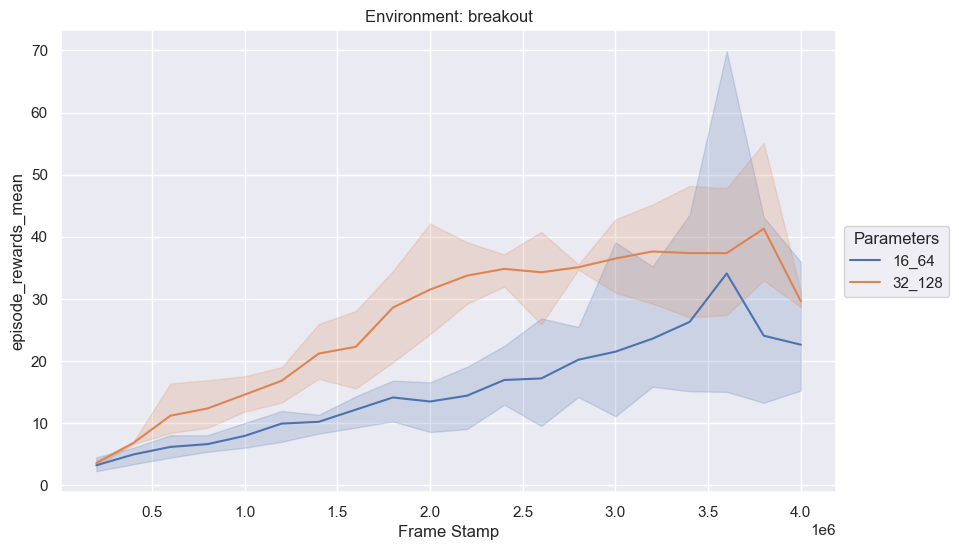

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_metric = 'episode_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']

# Extract unique environments
environments = validation_df['environment'].unique()

for env in environments:
    env_df = validation_df[validation_df['environment'] == env]
    # env_df['parameters'] = env_df[['redo.redo_freq', 'redo.tau', 
    #                                'agent_params.args_.target_model_update_freq']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    
    print(f'Plotting for environment: {env}')
    # print('redo.redo_freq', 'redo.tau', 'agent_params.args_.target_model_update_freq')
    
    # Create a new figure for each environment
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=env_df, x='frame_stamp', y=selected_metric, hue='model')
    plt.title(f'Environment: {env}')
    plt.ylabel(selected_metric)
    plt.xlabel('Frame Stamp')

    # Place the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
    plt.show()

Plotting for environment: breakout
agent_params.args_.target_model_update_freq


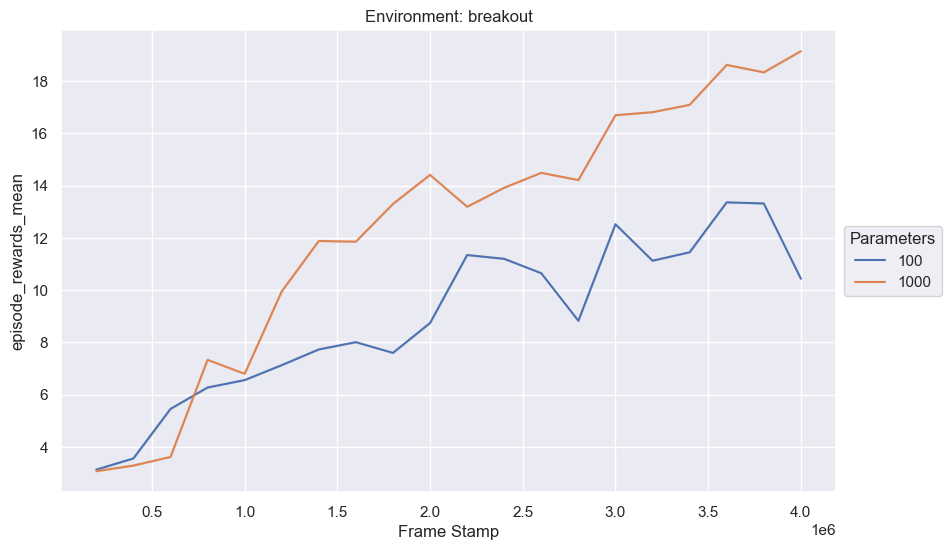

Plotting for environment: asterix
agent_params.args_.target_model_update_freq


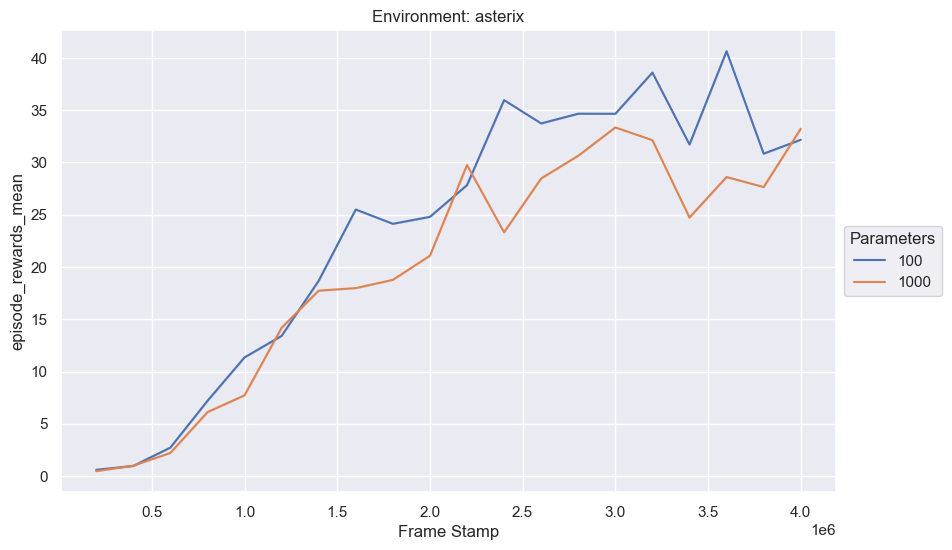

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_metric = 'episode_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']

# Extract unique environments
environments = validation_df['environment'].unique()

for env in environments:
    env_df = validation_df[validation_df['environment'] == env]
    env_df['parameters'] = env_df[['agent_params.args_.target_model_update_freq']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    
    print(f'Plotting for environment: {env}')
    print('redo.redo_freq', 'redo.tau', 'agent_params.args_.target_model_update_freq')
    
    # Create a new figure for each environment
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=env_df, x='frame_stamp', y=selected_metric, hue='parameters')
    plt.title(f'Environment: {env}')
    plt.ylabel(selected_metric)
    plt.xlabel('Frame Stamp')

    # Place the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
    plt.show()